<a href="https://colab.research.google.com/github/PiotrKapusta135/RedditClassifier/blob/master/Reddit_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reddit Classifier

In [80]:
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import string

from gensim.models import word2vec

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cars = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/cars_titles.csv')
cooking = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/cooking_titles.csv')
gaming = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/gaming_titles.csv')
movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/movies_titles.csv')
political = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/political_titles.csv')
science = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/science_titles.csv')
soccer = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/soccer_titles.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Reddit_test_data_final.csv')


In [5]:
test.head()

,Unnamed: 0,Title,Category
0,0,"Car with moderate underbody rust, what’s the b...",cars
1,1,Tesla’s Autopilot ‘tricked’ to operate without...,cars
2,2,How does Tesla model X collision evasion/detec...,cars
3,3,Cold start of my 81 Steyr 126. Wasn't very hap...,cars
4,4,What does one do about a 5/10 underbody rust?,cars


In [6]:
test['Category'].value_counts()

political    1000
cooking      1000
movies       1000
gaming       1000
cars         1000
soccer       1000
science      1000
Name: Category, dtype: int64

In [8]:
titles = pd.concat([cars, cooking, gaming, movies, political, science, soccer])

In [9]:
titles.drop('Unnamed: 0',axis=1, inplace=True)
test.drop('Unnamed: 0',axis=1, inplace=True)

In [10]:
titles.sample(5)

,Title,Category
6886,"First snowfall of the year, let's have some do...",cars
8603,PS5 Review and specification.,gaming
13370,Biden administration revives plan to put Harri...,political
832,Historical movies that share historical figures,movies
14893,PolitiFact - Antifa.com now redirects to White...,political


In [11]:
titles_categories = titles['Category'].unique()

In [12]:
def generate_text(categories):
    strings = []
    for category in categories:
        text = " ".join(title for title in titles[titles['Category'] == category]['Title'])
        strings.append(text)
    return strings

In [13]:
stopwords = set(STOPWORDS)

In [14]:
def generate_WordCloud():
    clouds = []
    for string in generate_text(titles_categories):
        cloud = WordCloud(stopwords=stopwords).generate(string)
        clouds.append(cloud)
    return clouds

In [15]:
clouds = generate_WordCloud()

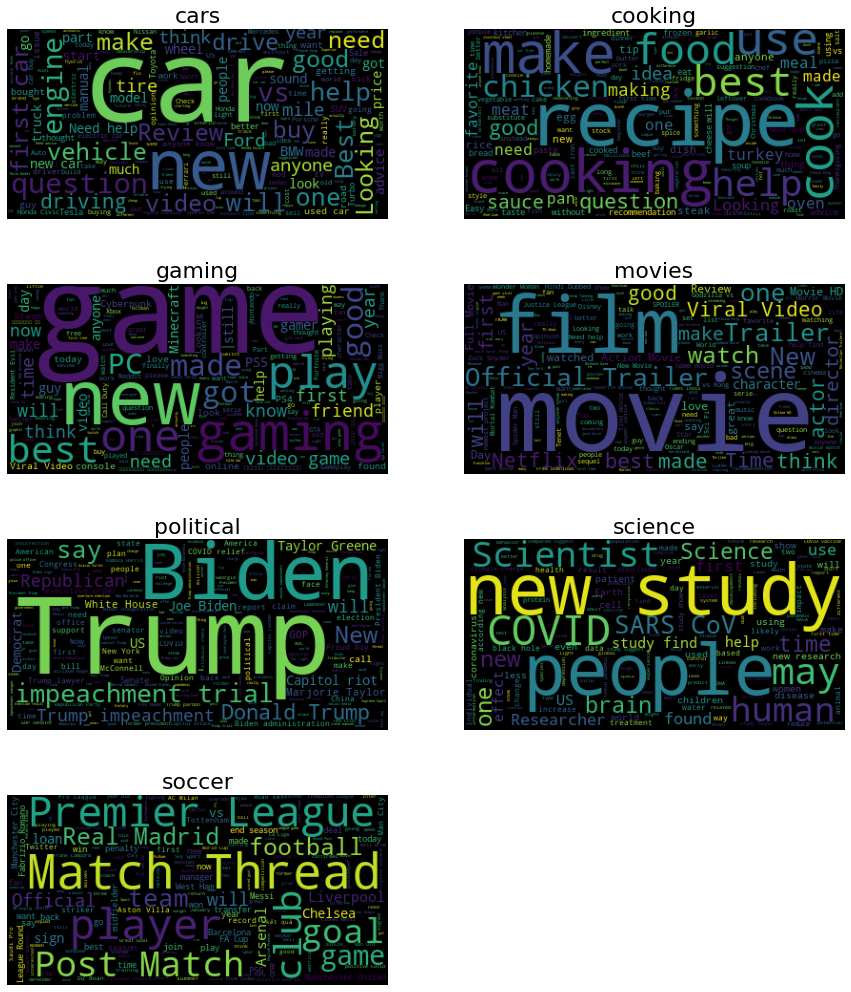

In [16]:
fig = plt.figure(figsize=(15, 18))
for i, cloud in enumerate(clouds):
    fig.add_subplot(4,2,i+1)
    plt.title(titles_categories[i], fontsize = 22)
    plt.axis('off')
    plt.imshow(cloud)
plt.show()

## EDA

In [17]:
missing = titles.isnull().sum()
print('Missing values:\n{}'.format(missing))

Missing values:
Title       0
Category    0
dtype: int64


In [18]:
#reducer = umap.w
#map = map.fit_transform(titles)

## Preprocessing

In [19]:
titles['Title'].head(1)

0    Gangster just saying
Name: Title, dtype: object

In [20]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

remove_punctuation = lambda text: text.translate(str.maketrans('','', string.punctuation))
tokenize = lambda text: nltk.word_tokenize(text)
#remove_whitespace = lambda text: [x.strip(' ') for x in text]
remove_stopwords = lambda text: ' '.join([word for word in text.split() if word not in stopwords])
remove_numbers = lambda text: ' '.join([word for word in text.split() if not word.isdigit()])
lemmatization = lambda text: ' '.join([lemmatizer.lemmatize(word, pos='v') for word in text.split()])

def remove_whitespaces(text):
    texty = []
    for token in text:
        token = token.split()[0]
        texty.append(token)
    return texty

def preprocess(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = lemmatization(text)
    #text = tokenize(text)
    #ext = remove_whitespaces(text)
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
titles['Title_new'] = titles['Title'].apply(preprocess)
test['Title'] = test['Title'].apply(preprocess)

In [22]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(titles['Title_new'])
titles['Title_new'] = tokenizer.texts_to_sequences(titles['Title_new'])
test['Title'] = tokenizer.texts_to_sequences(test['Title'])

In [23]:
titles.head()

,Title,Category,Title_new
0,Gangster just saying,cars,[15]
1,1 quart motor oil in transmission no choice bu...,cars,"[1176, 277, 729, 2059, 98, 3744, 11, 229]"
2,A Hypothetical Car Buying Situation... Need Ad...,cars,"[5, 35, 1515, 21, 217]"
3,What is cash flow statement,cars,"[1892, 2308, 1422]"
4,Tyres Services,cars,"[5836, 549]"


In [24]:
titles.drop('Title', axis=1, inplace=True)

In [25]:
titles = titles.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [26]:
test

,Title,Category
0,"[432, 1849, 4965, 337, 6898, 143, 3633]",gaming
1,"[2697, 6, 8787, 3375, 9713, 727, 659, 251]",movies
2,"[636, 174]",soccer
3,"[112, 1781]",cars
4,"[1406, 628, 686, 4478, 884, 1471]",science
...,...,...
6995,"[636, 174]",movies
6996,"[324, 1418, 9827, 1149, 799, 1965, 170, 5054, ...",science
6997,"[3473, 1178]",cars
6998,"[132, 1046, 1425]",gaming


In [27]:
category_encoder = LabelEncoder()
category_encoder.fit(titles['Category'])

titles['Category'] = category_encoder.transform(titles['Category'])
test['Category'] = category_encoder.transform(test['Category'])

In [28]:
titles.head()

,Category,Title_new
0,0,"[915, 1152, 403, 1274, 207, 490, 3579, 2234, 2..."
1,2,"[2, 635, 1246]"
2,6,"[120, 1330, 2611, 5265, 283, 401, 75, 861, 770..."
3,6,"[1181, 850]"
4,1,"[82, 1289, 82, 462, 452, 336, 1170, 4526]"


In [29]:
titles = titles[titles['Title_new'].str.len() > 2] #removing short titles that add noise to the data

## Modeling

In [30]:
X = titles['Title_new']
y = titles['Category']
X = sequence.pad_sequences(X, maxlen=70)
y = to_categorical(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, shuffle=True)

X_test = test['Title']
y_test = test['Category']
X_test = sequence.pad_sequences(X_test, maxlen = 70)
y_test = to_categorical(y_test)

In [32]:
model = Sequential()
model.add(Embedding(10000, 64, input_length=70))

model.add(LSTM(32, dropout=0.5, return_sequences=True))
model.add(LSTM(64, dropout=0.5, return_sequences=True))
model.add(LSTM(64, dropout=0.5, return_sequences=True))
model.add(LSTM(128, dropout=0.5))
#model.add(LSTM(256, dropout = 0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 64)            640000    
_________________________________________________________________
lstm (LSTM)                  (None, 70, 32)            12416     
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 64)            24832     
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 809,991
Trainable params: 809,991
Non-trainable params: 0
__________________________________________________

In [49]:
#history = model.fit(X_train, y_train, epochs = 10, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/10
  3/759 [..............................] - ETA: 5:42 - loss: 0.2994 - accuracy: 0.8958

KeyboardInterrupt: ignored

In [50]:
model = tf.keras.models.load_model('/content/2804.h5')

1. Word2Vec
2. Gotowy embedding
3. pos

In [40]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy)+1)

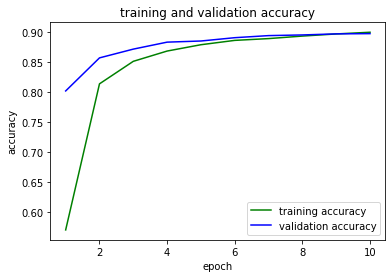

In [36]:
plt.plot(epochs, train_accuracy, 'g', label='training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='validation accuracy')
plt.title('training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

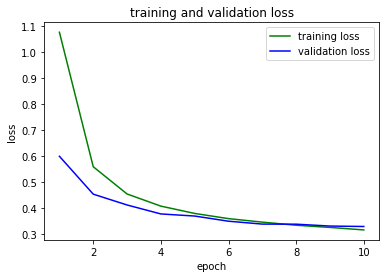

In [37]:
plt.plot(epochs, train_loss, 'g', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

1. 2x64 d = 0.3, 1x128 d =0.4, wym = 8 , acc = 0,8693
2. 2x64 d = 0.3, 1x128 d =0.4, wym = 16, acc = 0.8724
3. 2x64 d = 0.3,, 1x128 d =0.4, wym = 32, acc = 0.8769

In [38]:
model.evaluate(X_test, y_test)

219/219 [==============================] - 10s 46ms/step - loss: 0.6806 - accuracy: 0.7886


[0.6805838346481323, 0.7885714173316956]

In [60]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(1)
y_test = y_test.argmax(1)

In [41]:
#model.save('2804.h5')

In [65]:
cf = tf.math.confusion_matrix(y_test, y_pred)

In [66]:
cf

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[866,  35,  58,   8,   8,  21,   4],
       [  8, 909,  40,   8,   2,  29,   4],
       [ 33,  36, 759,  89,  11,  52,  20],
       [ 43,  54, 157, 575,  25, 129,  17],
       [ 15,  18, 123,  56, 672,  97,  19],
       [ 11,  26,  65,  24,  20, 852,   2],
       [  7,   5,  54,  24,  18,   5, 887]], dtype=int32)>

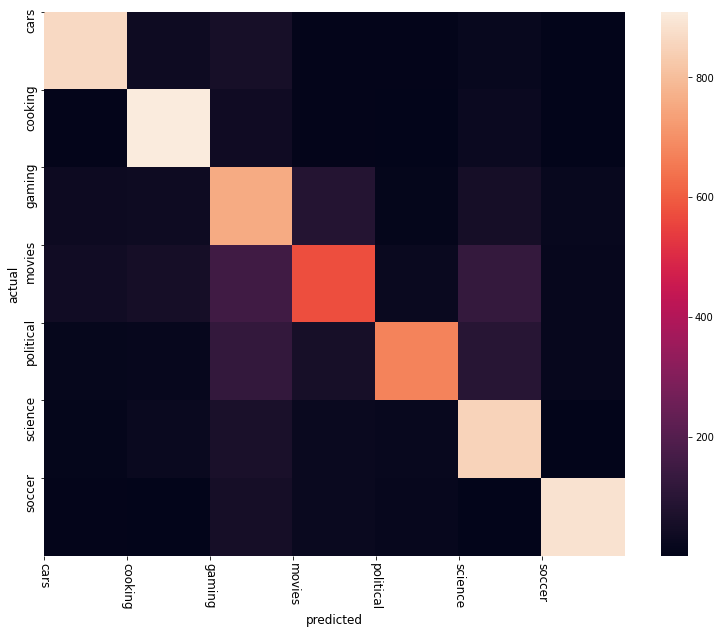

In [94]:
plt.figure(figsize=(13,10))
sns.heatmap(cf)
plt.yticks(list(np.arange(7)), titles_categories, size=12, rotation=90)
plt.xticks(list(np.arange(7)), titles_categories, size=12, rotation=270)
plt.xlabel('predicted', size=12)
plt.ylabel('true', size=12)
plt.show()